## Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run /content/drive/MyDrive/churn/Packages.ipynb

## Reading dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/churn/telco_churn.csv')
df = df.drop('Unnamed: 0', axis =1)
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1-12,tenure_group_13-24,tenure_group_25-36,tenure_group_37-48,tenure_group_49-60,tenure_group_61-72
0,0,29.85,29,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [ ]:
x = df.drop('Churn', axis =1)
x.dtypes

In [5]:
y = df['Churn']
y.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

## Train Test Split 

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [7]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x,y)
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled,y_resampled,test_size=0.2)

# Decision Tree Classifier

### Standard model

What could we expect from this model ? If we want to maximize the precision of the model, we should optimize the number of tree branches, that means not specify the 'max_depth' parameter. If we want to maximize recall, we do not need to go as deeper in the tree as we should do for a precision maximization.
That means, lets try with max_depth = 3 for ploting a simple tree. 

In [8]:
model_dt = DecisionTreeClassifier(criterion = 'gini', random_state= 100, max_depth=3, min_samples_leaf=8)

In [9]:
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=100)

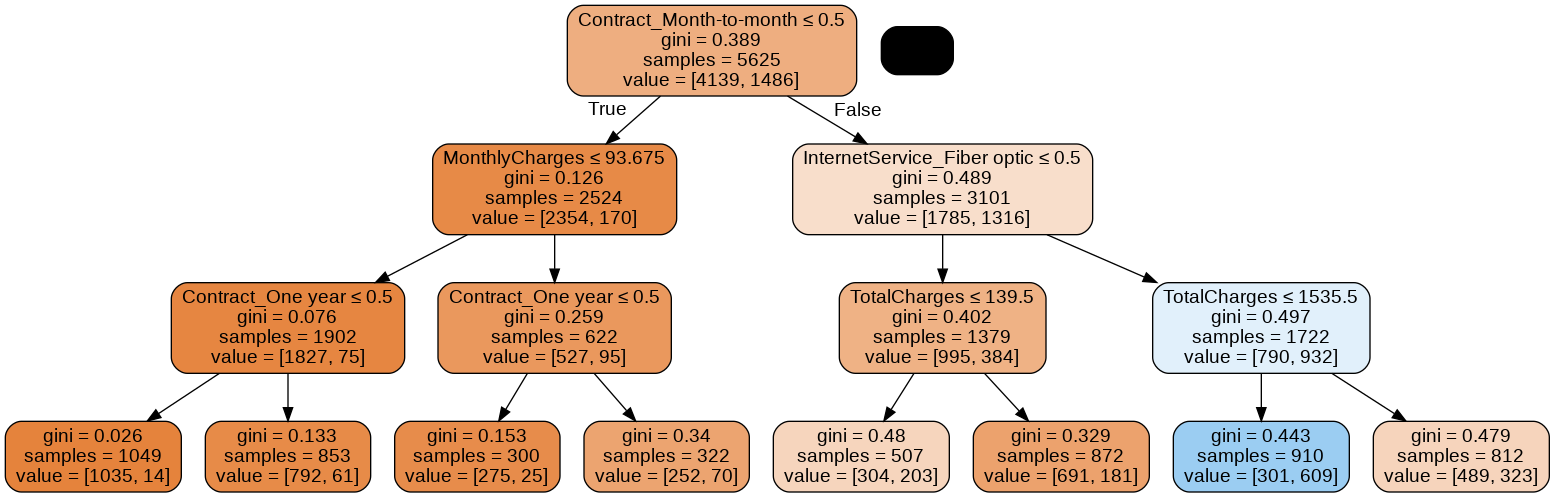

In [10]:
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data
feature_cols = x.columns
dot_data = StringIO()
export_graphviz(model_dt, out_file = dot_data,
                filled=True,rounded=True,
                special_characters=True, feature_names=feature_cols)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Reading : **Root** and **decision nodes** (the higher stairs) contain questions which split into **subnodes**. The **leaf nodes** (the lowest one) are nodes that don't split into more nodes but are the ones where classes are assigned by majority vote. 
We read this Tree from the root node to the leaf node. 


---


Starting at the root node, we first ask "Is the contrat is Month-by-month"? (Since the variable is 0 or 1, 0.5 make the threshold). 
If it's true, so we're step down to the value of Monthly Charges, True at right and False at left. 
Value is a vector that indicates the well classify raws (first element) and the wrong one (second coordinate) 


---


Without max_depth, classification trees are a greedy algorithm which means by default it will continue to split until it has a **pure node**. Without max_depth, this often leads to overfitting on the training dataset. 

Decision trees split on the feature and correspondning split point that results in the largest **information gain** (IG) for a given criterion (here, gini).
IG = Information before splitting - information after splitting.  

If we look at the upper two stages, we have :

In [11]:
# Gini for parent
print(1 - ((4124/(4124+1501))**2+(1501/(4124+1501))**2))
# Gini for child node (left)
print(1 - ((2336/(2336+171))**2+(171/(2336+171))**2))
# Gini for child node (right)
print(1 - ((1788/(1788+1330))**2+(1330/(1788+1330))**2))
# Information gain 
print(0.391- 0.127*(2507/5625)-0.489*(3118/5625))

0.3912769738271604
0.1271130901286528
0.48921180622271887
0.06333937777777776


In [12]:
feat_importance = model_dt.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, model_dt.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict,orient='index')
feat_imp.rename(columns={0:'FeatureImportance'},inplace=True)
feat_imp.sort_values(by=['FeatureImportance'],ascending=False).head(8)

,FeatureImportance
Contract_Month-to-month,0.624135
InternetService_Fiber optic,0.186060
TotalCharges,0.153209
MonthlyCharges,0.021173
Contract_One year,0.015423
Contract_Two year,0.000000
TechSupport_Yes,0.000000
StreamingTV_No,0.000000


As we can see, with max_depth = 3, only 6 variables have a significant importance inside the model. 

We finally look at the metrics of interest, here they are precision (for qualitative need) and recall (for a quantitative need).

In [13]:
y_pred = model_dt.predict(x_test)
report = metrics.classification_report(y_test, y_pred, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
print('precision : {}'.format(precision))
print('recall : {}'.format(recall))

precision : 0.7598162071846282
recall : 0.666525579308094


In [14]:
print(metrics.confusion_matrix(y_test,y_pred))

[[964  60]
 [233 150]]


min_samples_leaf and max_depth are parameters used to prevent a tree from overfiting. Cost complexity pruning (ccp) provides another option to control the size of a tree. What why ccp will be used next. 

### Tune the Depth of a Tree

In [15]:
max_depth_range = list(range(1,10))
precisions = []
recalls = []
for depth in max_depth_range:
  clf = DecisionTreeClassifier(max_depth=depth, random_state=100)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  report = metrics.classification_report(y_test, y_pred, output_dict=True)
  precision = report['macro avg']['precision']
  recall = report['macro avg']['recall']
  precisions.append(precision)
  recalls.append(recall)
print(precisions)
print(recalls)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3638948116560057, 0.7068276551035171, 0.7598162071846282, 0.7490122914837577, 0.7340707729853042, 0.7305916305916307, 0.7179907179907179, 0.7121232328620966, 0.6999385072341018]
[0.5, 0.7143235966057442, 0.666525579308094, 0.6938119594484334, 0.7024926566579635, 0.6711304667101827, 0.6832393317558747, 0.6906043468505222, 0.6757557522845953]


The precision looks to be at its peak for max_depth = 4. And it's for max_depth = 2 that the recall is at its peak. 

### Cost Complexity pruning
[Pruning technique](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py) is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned.
We are looking for a precision optimization model.

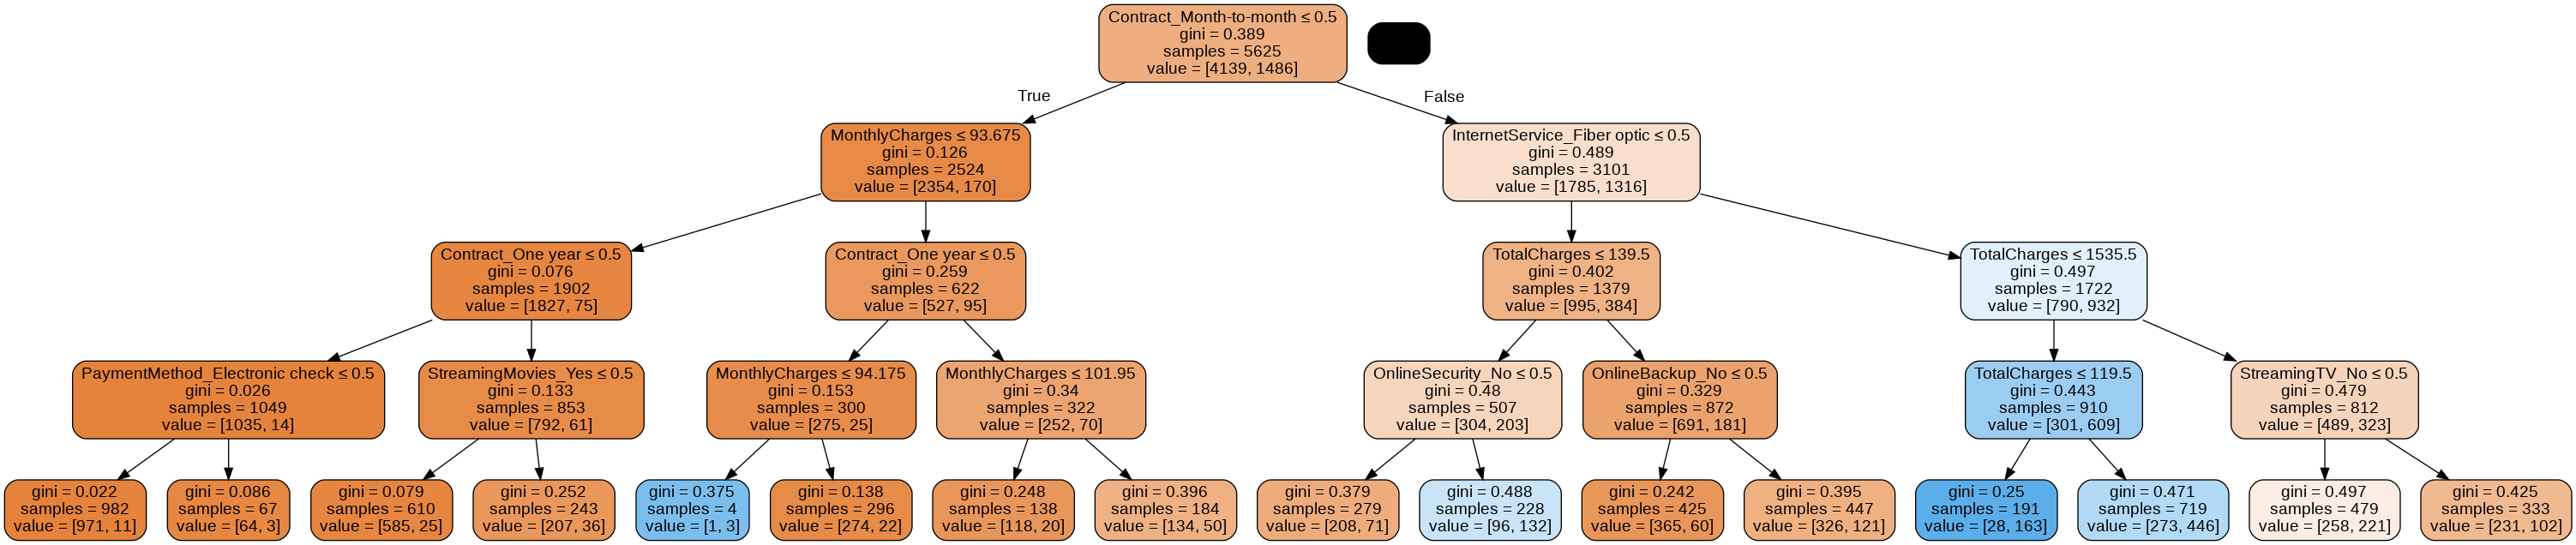

In [16]:
from six import StringIO
from IPython.display import Image
model_prune = DecisionTreeClassifier(criterion = 'gini', random_state= 100,max_depth =4)
model_prune.fit(x_train, y_train)
feature_cols = x.columns
dot_data = StringIO()
export_graphviz(model_prune, out_file = dot_data,
                filled=True,rounded=True,
                special_characters=True, feature_names=feature_cols)
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [17]:
feat_importance = model_prune.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, model_prune.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict,orient='index')
feat_imp.rename(columns={0:'FeatureImportance'},inplace=True)
feat_imp.sort_values(by=['FeatureImportance'],ascending=False).head(12)

,FeatureImportance
Contract_Month-to-month,0.555828
InternetService_Fiber optic,0.165697
TotalCharges,0.162137
OnlineSecurity_No,0.041395
MonthlyCharges,0.028477
StreamingTV_No,0.014803
Contract_One year,0.013735
OnlineBackup_No,0.011453
StreamingMovies_Yes,0.006254
PaymentMethod_Electronic check,0.000222


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

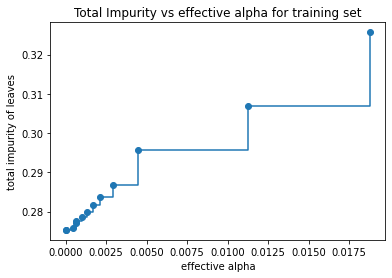

In [18]:
path = model_prune.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Minimal ccp finds the node with the "weakest link". The weakest link is characterized by an effective akpha, where the nodes with the smallest effective alpha, where the nodes with the smallest effective alpha are pruned first. to get an idea of what values of ccp_alpha could be appropriate, sklearn provides the above function that returns the effective alphas and the corresponding total leaf impurities at each step of pruning process. As alpha increases, more of the tree is pruned, which increases the total impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves. 

In [19]:
clfs = []
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state= 0, max_depth = 4,
                               ccp_alpha=ccp_alpha)
  clf.fit(x_train, y_train)
  clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha : {}".format(
    clfs[-1].tree_.node_count,ccp_alphas[-1])
)

Number of nodes in the last tree is: 1 with ccp_alpha : 0.06306310095607187


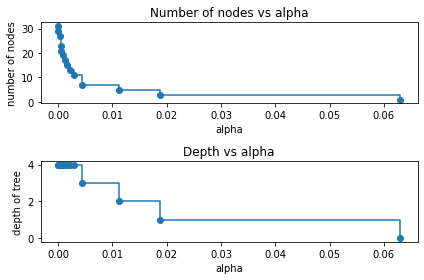

In [20]:
#clfs = clfs[:-1]
#cp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2,1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Here above we show that the number of nodes and tree depth decreases as alpha increases

In [21]:
y_preds = [clf.predict(x_test) for clf in clfs]
reports = [metrics.classification_report(y_test, y_pred, output_dict=True,zero_division=1) for y_pred in y_preds]
precisions = []
precision = [report['macro avg']['precision'] for report in reports]
precisions.append(precision)
print(precisions)

[[0.7490122914837577, 0.7490122914837577, 0.7490122914837577, 0.7490122914837577, 0.750354819633353, 0.750354819633353, 0.750354819633353, 0.750354819633353, 0.750354819633353, 0.750354819633353, 0.7598162071846282, 0.7068276551035171, 0.8638948116560057, 0.8638948116560057]]


It's looks like pruning the tree depth doesn't improve the model. The problem might be the imbalanced dataset we are facing, to handle it, we could look for upsampling method.

### Using an upSampling method, with SMOTEEN 

In [22]:
model_dt_smote = DecisionTreeClassifier(criterion = "gini", random_state=100, max_depth=4, min_samples_leaf=8)

In [23]:
model_dt_smote.fit(xr_train, yr_train)
yr_predict = model_dt_smote.predict(xr_test)

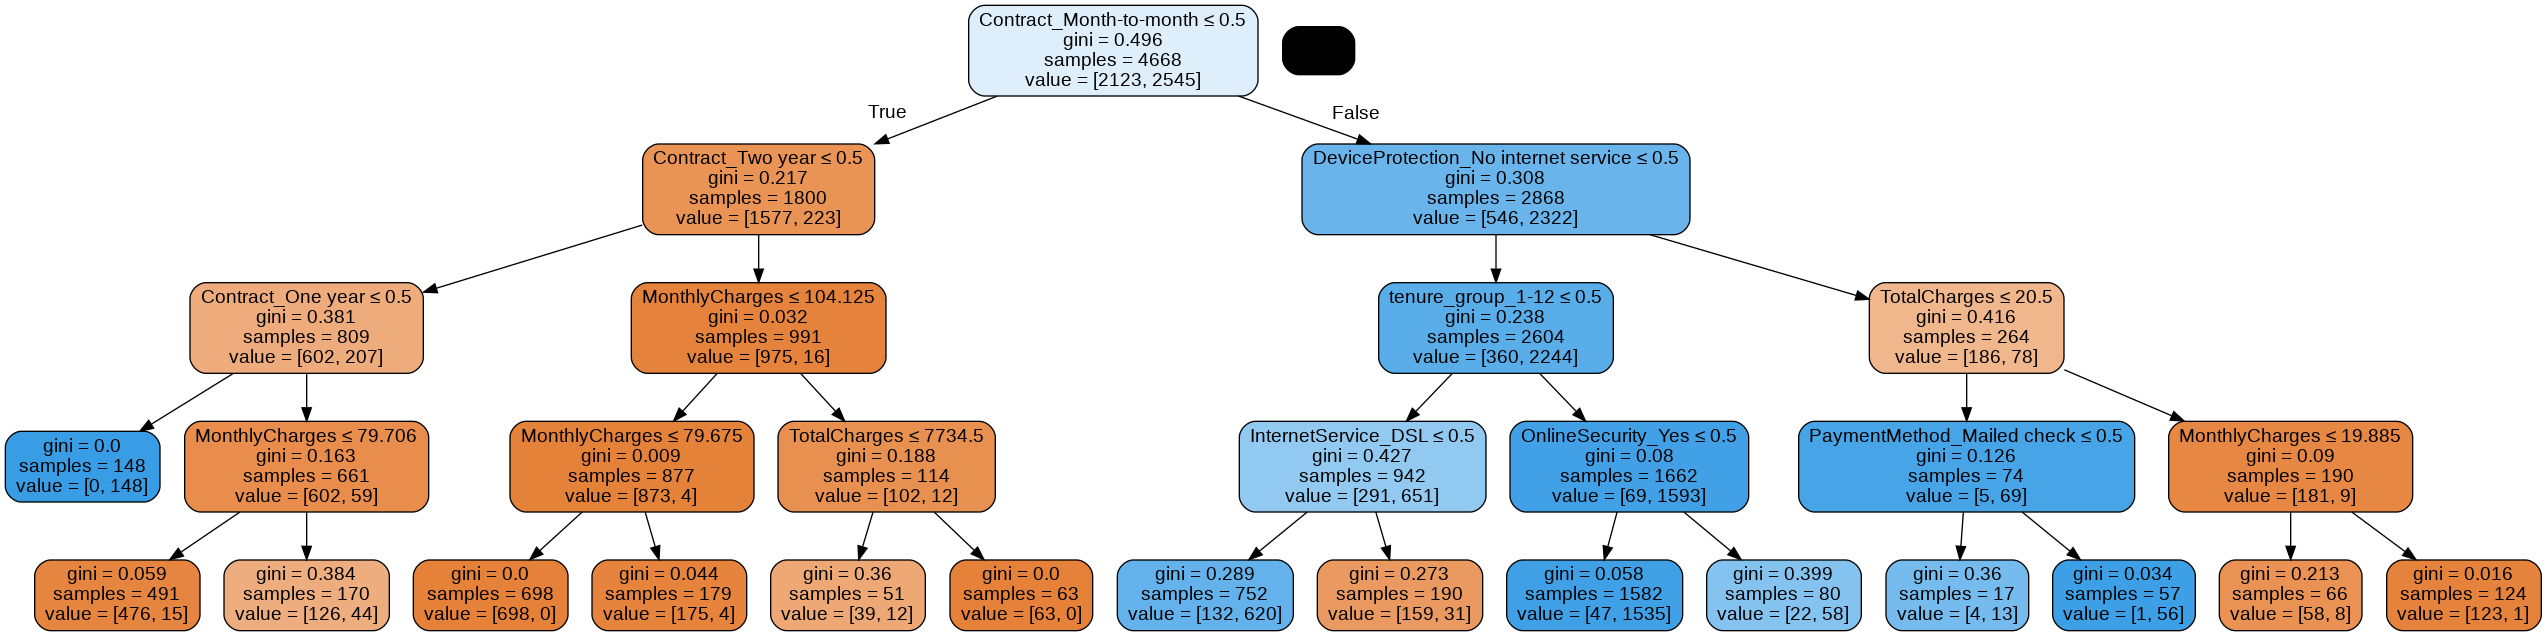

In [24]:
feature_cols = x.columns
dot_data = StringIO()
export_graphviz(model_dt_smote, out_file = dot_data,
                filled=True,rounded=True,
                special_characters=True, feature_names=feature_cols)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [25]:
feat_importance_smote = model_dt_smote.tree_.compute_feature_importances(normalize=False)
feat_imp_dict_smote = dict(zip(feature_cols, model_dt_smote.feature_importances_))
feat_imp_smote = pd.DataFrame.from_dict(feat_imp_dict_smote,orient='index')
feat_imp_smote.rename(columns={0:'FeatureImportance'},inplace=True)
feat_imp_smote.sort_values(by=['FeatureImportance'],ascending=False).head(12)

,FeatureImportance
Contract_Month-to-month,0.585077
Contract_One year,0.112846
DeviceProtection_No internet service,0.086484
InternetService_DSL,0.074630
TotalCharges,0.048692
tenure_group_1-12,0.048367
Contract_Two year,0.028798
MonthlyCharges,0.009255
OnlineSecurity_Yes,0.005155
PaymentMethod_Mailed check,0.000699


In [26]:
report_smote = metrics.classification_report(yr_test,yr_predict, output_dict=True,zero_division=1)
precision_smote = report_smote['macro avg']['precision']
recall_smote = report_smote['macro avg']['recall']
print('precision : {}'.format(precision_smote))
print('recall : {}'.format(recall_smote))

precision : 0.9356192530640283
recall : 0.9296007321000933


In [27]:
print(metrics.confusion_matrix(yr_test,yr_predict))

[[467  54]
 [ 24 622]]


Adding Upsampling into the model, precision (quality measure) and recall (quantitative measure) are much better compared to standard model.

# Random Forest Classifier

As I done it for DecisionTree, I could try to optimize the depth and others parameters, but we have seen that improving the model is about upsampling the training data. 

### Standard

In [28]:
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=100, max_depth=6, min_samples_leaf=8)

In [29]:
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [30]:
y_pred_rf=model_rf.predict(x_test)

In [31]:
report_rf = metrics.classification_report(y_test,y_pred_rf, output_dict=True,zero_division=1)
precision_rf = report_rf['macro avg']['precision']
recall_rf = report_rf['macro avg']['recall']
print('precision : {}'.format(precision_rf))
print('recall : {}'.format(recall_rf))

precision : 0.7518363609879934
recall : 0.6851516604112271


In [32]:
print(metrics.confusion_matrix(y_test,y_pred_rf))

[[946  78]
 [212 171]]


The insights give by the standard Decision tree are the same here above, precision is too low as recall is.
Let's look how upsampling could help

### With upsampling

In [33]:
model_rf_smote = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=100, max_depth=6, min_samples_leaf=8)

In [34]:
model_rf_smote.fit(xr_train,yr_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [35]:
yr_predict1 = model_rf_smote.predict(xr_test)
report_rf_smote = classification_report(yr_test,yr_predict1,output_dict=True,zero_division=1)
precision_rf_smote = report_rf_smote['macro avg']['precision']
recall_rf_smote = report_rf_smote['macro avg']['recall']
print('precision : {}'.format(precision_rf_smote))
print('recall : {}'.format(recall_rf_smote))

precision : 0.9425279593711167
recall : 0.9380522690943233


Using RF Classifier, we are able to match DT classifier, even roughly better looking at the precision.

##KNN Classifier

In kNN Classification, the output is a classe membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. If k=1, then the object is simply assigned to the class of that single nearest neighbor. 

### Standard

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
def confusion_matrix_plot(y_test, y_pred):
    plt.matshow(confusion_matrix(y_test, y_pred))
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)
    plt.show()

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
precision : 0.6892512239286432
recall : 0.6439052810868147
[[915 109]
 [232 151]]


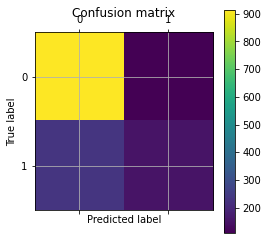

None


In [38]:
model_knn = KNeighborsClassifier(n_jobs=-1)
model_knn.fit(x_train,y_train)
print(model_knn.get_params())
y_pred_knn = model_knn.predict(x_test)
report_knn = classification_report(y_test,y_pred_knn,output_dict=True,zero_division=1)
precision_knn = report_knn['macro avg']['precision']
recall_knn = report_knn['macro avg']['recall']
print('precision : {}'.format(precision_knn))
print('recall : {}'.format(recall_knn))
print(metrics.confusion_matrix(y_test,y_pred_knn))
print(confusion_matrix_plot(y_test,y_pred_knn))

### Upsampling for KNN

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
precision : 0.9494401773318
recall : 0.9482062953477178
[[488  33]
 [ 26 620]]


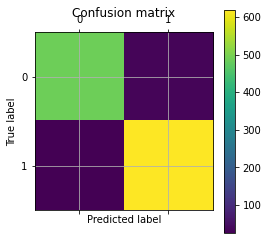

None


In [39]:
model_knn_smote = KNeighborsClassifier(n_jobs=-1)
model_knn_smote.fit(xr_train,yr_train)
print(model_knn.get_params())
y_pred_knn_smote = model_knn_smote.predict(xr_test)
report_knn_smote = classification_report(yr_test,y_pred_knn_smote,output_dict=True,zero_division=1)
precision_knn_smote = report_knn_smote['macro avg']['precision']
recall_knn_smote = report_knn_smote['macro avg']['recall']
print('precision : {}'.format(precision_knn_smote))
print('recall : {}'.format(recall_knn_smote))
print(metrics.confusion_matrix(yr_test,y_pred_knn_smote))
print(confusion_matrix_plot(yr_test,y_pred_knn_smote))

## Ensemble method : Stacking Classifier

[Leo Breiman' stacking](https://link.springer.com/article/10.1007/bf00117832) is an ensemble method that, empirically, has always gives better results than each individual model. As Breiman build it, the final estimator is Rigde regression applied with cross validation. Indeed, such set-up avoid high correlations between each model and over-fitting on data. 

[References of sklearn' stacking is Wolpert, 1992, Breiman own references](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [41]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ("dt", model_dt_smote),
    ("knn", model_knn_smote),
    ("rf", model_rf_smote),
    ]

stacking_model = StackingClassifier(
    estimators,
    final_estimator=None, 
    cv = None,
)
stacking_model.fit(xr_train,yr_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=4,
                                                       min_samples_leaf=8,
                                                       random_state=100)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('rf',
                                RandomForestClassifier(max_depth=6,
                                                       min_samples_leaf=8,
                                                       random_state=100))])

precision : 0.9655072074491897
recall : 0.9634380775241705
[[495  26]
 [ 15 631]]


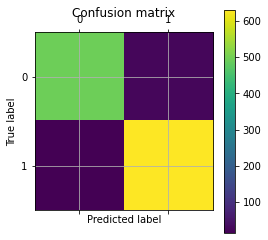

None


In [42]:
y_pred_stacking = stacking_model.predict(xr_test)
report_stacking = classification_report(yr_test,y_pred_stacking,output_dict=True,zero_division=1)
precision_stacking = report_stacking['macro avg']['precision']
recall_stacking = report_stacking['macro avg']['recall']
print('precision : {}'.format(precision_stacking))
print('recall : {}'.format(recall_stacking))
print(metrics.confusion_matrix(yr_test,y_pred_stacking))
print(confusion_matrix_plot(yr_test,y_pred_stacking))

## Conclusion

In [43]:
models = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest','kNN','Stacking'],
    'Precision': [precision_smote, precision_rf_smote,precision_knn_smote,precision_stacking],
    'Recall': [recall_smote, recall_rf_smote,recall_knn_smote,recall_stacking]})
models

,Model,Precision,Recall
0,Decision Tree,0.935619,0.929601
1,Random Forest,0.942528,0.938052
2,kNN,0.949440,0.948206
3,Stacking,0.965507,0.963438


And here, in facts, Recall and Precision are the highest ones using Stacking Classifier

## Save the models

In [44]:
import pickle
import datetime

def save_model(model,method):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  pickle.dump(model,open('model_{}.sav'.format(method),'wb'))
  return

In [45]:
save_model(model_dt_smote,"dt")
save_model(model_rf_smote,"rf")
save_model(model_knn_smote,"knn")
save_model(stacking_model,"Stacking")